In [1]:
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as ocm
from scipy import stats
from scipy.signal import detrend
import pandas as pd
import pickle

proj_dir = '/home/ubuntu/bigStick/antarctic_melting'
data_dir = os.path.join(proj_dir,'data','analysis')
raw_dir = os.path.join(data_dir,'raw')
int_dir = os.path.join(data_dir,'interim')
fig_dir = os.path.join(proj_dir,'reports','tidal_melting','figures')
tab_dir = os.path.join(proj_dir,'reports','tidal_melting','tables')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)
tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)

%load_ext autoreload
%autoreload 2

from pySSA.mySSA import mySSA
from log_progress import log_progress
from rotate_vector_roms import rotate_vector_roms
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves

# 1. Artificiall signal construction

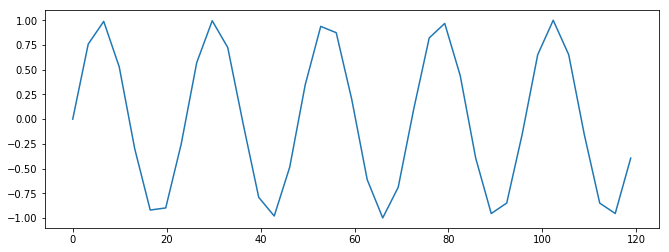

In [91]:
periods = [23.93, 25.82, 24.07, 26.87]
periods = [24.07]
t = np.arange(0,5*24,3.3)
signal = np.zeros_like(t)
for p in periods:
    signal = signal + np.sin(2*np.pi/p*t)
plt.plot(t,signal)
plt.show()
tsPure = pd.Series(signal, index=pd.date_range("2007",freq='H',periods=np.size(signal)))

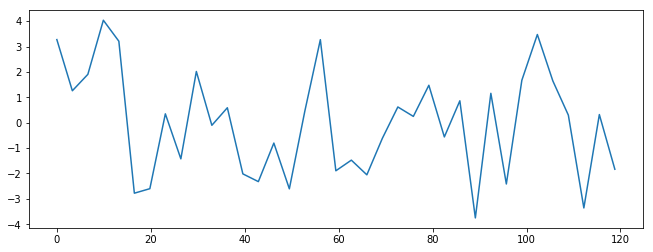

In [97]:
noise = np.random.normal(0,1,np.size(t))
signal = signal + noise
plt.plot(t,signal)
plt.show()

# 2. Decomposition with SSA and goodness of fit

In [98]:
ts = pd.Series(signal, index=pd.date_range("2007",freq='H',periods=np.size(signal)))
ssa = mySSA(ts)

In [99]:
[x for x in dir(ssa) if '__' not in x and x[0]!='_']

['decompose',
 'diagonal_averaging',
 'embed',
 'forecast_recurrent',
 'freq',
 'get_contributions',
 'ts',
 'ts_N',
 'ts_name',
 'ts_v',
 'view_reconstruction',
 'view_s_contributions',
 'view_time_series']

In [100]:
ssa.embed(embedding_dimension=4, verbose=True)
ssa.decompose(verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  4
Trajectory dimensions	: (4, 34)
Complete dimension	: (4, 34)
Missing dimension     	: (4, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 4
Dimension of projection space	: 4
Characteristic of projection	: 1.0


In [115]:
ssa.

matrix([[ 3.27304713,  1.25750705,  1.90366236,  4.03510062,  3.20900305,
         -2.77668724, -2.59907378,  0.3485298 , -1.42394777,  2.01730067,
         -0.10299308,  0.58813361, -2.01568563, -2.3206645 , -0.80237987,
         -2.60466457,  0.45911307,  3.27020956, -1.89410039, -1.47504114,
         -2.05315158, -0.61652283,  0.6194818 ,  0.24781963,  1.4741645 ,
         -0.56073934,  0.86232435, -3.75046082,  1.15709397, -2.41406483,
          1.67181286,  3.47333403,  1.64451353,  0.29783134],
        [ 1.25750705,  1.90366236,  4.03510062,  3.20900305, -2.77668724,
         -2.59907378,  0.3485298 , -1.42394777,  2.01730067, -0.10299308,
          0.58813361, -2.01568563, -2.3206645 , -0.80237987, -2.60466457,
          0.45911307,  3.27020956, -1.89410039, -1.47504114, -2.05315158,
         -0.61652283,  0.6194818 ,  0.24781963,  1.4741645 , -0.56073934,
          0.86232435, -3.75046082,  1.15709397, -2.41406483,  1.67181286,
          3.47333403,  1.64451353,  0.29783134, -3

In [123]:
ssa.S

matrix([[144.23966274,  24.97935159,   4.04391187, -31.73421818],
        [ 24.97935159, 144.80290227,  19.78823369,   3.9703495 ],
        [  4.04391187,  19.78823369, 143.32410835,  16.80723946],
        [-31.73421818,   3.9703495 ,  16.80723946, 143.06227697]])

In [125]:
w = np.fft.fft(ssa.S[0])
print(np.absolute(w))

[[141.52870803 151.23252811 155.03844121 151.23252811]]


In [114]:
ssa.Xs

{0: matrix([[ 0.89280571,  0.52485307,  3.62540051,  3.90859589,  0.37662858,
          -1.83145752, -2.0517573 , -0.11745476, -0.25265257,  1.76634547,
           0.79882336, -0.30226638, -1.01784851, -1.85938299, -2.43016692,
          -0.27729274,  1.7427163 ,  1.64336479, -1.45240965, -1.75113795,
          -1.32327639, -0.59956647,  0.7231196 ,  0.29812557,  1.94975522,
          -0.69524938,  0.07572974, -2.32942129, -1.31485823, -0.97177714,
           2.11178322,  3.58027864,  0.58173761, -0.35122564],
         [ 0.59674968,  0.35081082,  2.42321099,  2.61249826,  0.25173785,
          -1.22414282, -1.37139078, -0.07850654, -0.16887251,  1.18062204,
           0.53393206, -0.20203429, -0.68032806, -1.24280815, -1.62431907,
          -0.18534196,  1.16482835,  1.09842198, -0.97078792, -1.17045737,
          -0.88447549, -0.40074912,  0.4833318 ,  0.19926658,  1.30321278,
          -0.4647034 ,  0.05061762, -1.55698088, -0.8788488 , -0.64953404,
           1.41151199,  2.39305162

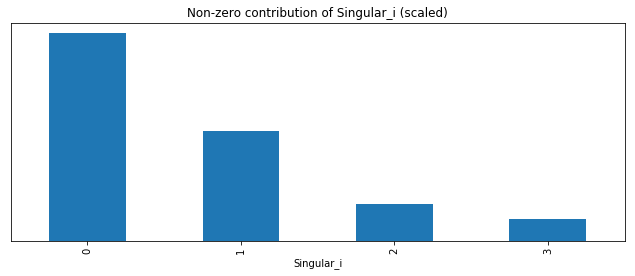

In [84]:
%matplotlib inline 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

ssa.view_s_contributions(adjust_scale=True)

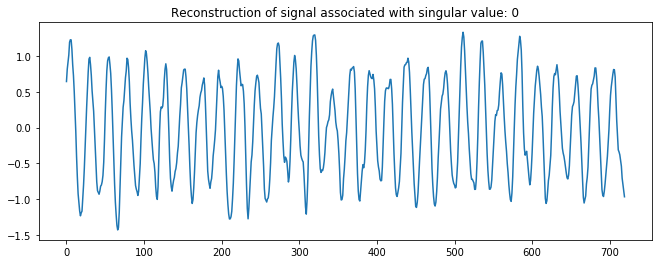

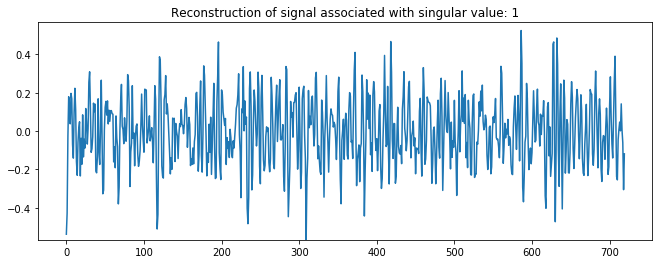

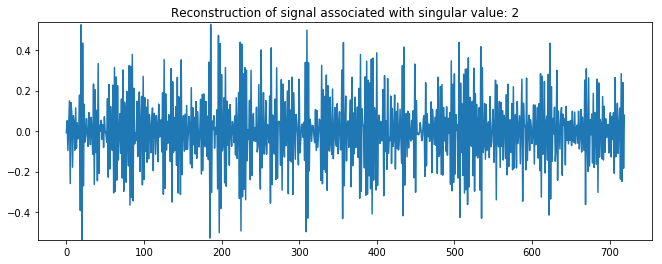

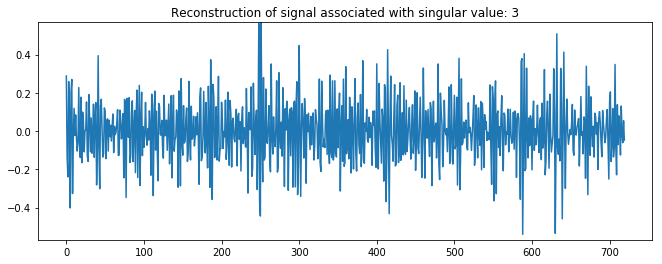

In [85]:
for i in range(4):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

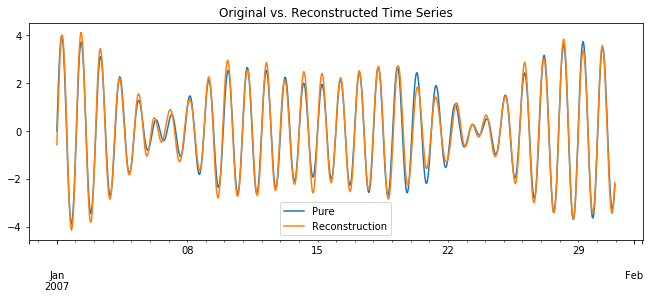

In [11]:
streams = [i for i in range(2)]
reconstructed = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams], 
                                          names=streams, return_df=True, plot=False)
ts_copy2 = ssa.ts.copy()
ts_copy2['Reconstruction'] = reconstructed.Reconstruction.values
ts_copy2['Pure'] = tsPure.values
ts_copy2.plot(y=['Pure','Reconstruction'],title='Original vs. Reconstructed Time Series')

# 3. Testing different window sizes (artifical and "real" signal)

In [49]:
def ssa_window(K):
    ssa.embed(embedding_dimension=K)
    ssa.decompose()
    streams = [i for i in range(2)]
    reconstructed = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams], 
                                              names=streams, return_df=True, plot=False)
    ts_copy2 = ssa.ts.copy()
    ts_copy2['Reconstruction'] = reconstructed.Reconstruction.values
    ts_copy2['Pure'] = tsPure.values
    #ts_copy2.plot(y=['Pure','Reconstruction'],title='Original vs. Reconstructed Time Series')
    #print(np.sum(ts_copy2['Reconstruction']**2 - ts_copy2['Pure']**2)/ts_copy2['Reconstruction'].size)
    #plt.show()
    return np.sum((ts_copy2['Reconstruction'] - ts_copy2['Pure'])**2)/ts_copy2['Reconstruction'].size

In [13]:
rmses = []
ws = np.arange(3,50,2)
for i in log_progress(ws):
    rmses.append(ssa_window(i))

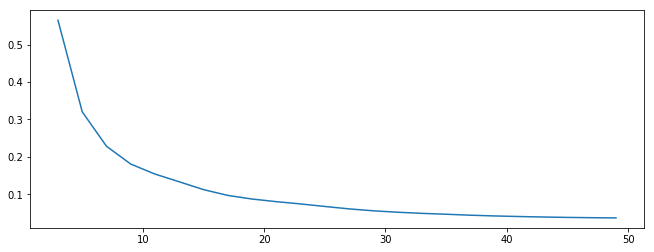

In [14]:
plt.plot(ws,rmses)

In [168]:
file_path = os.path.join(raw_dir,'waom4_hr','ocean_avg_0010.nc')
tides = xr.open_dataset(file_path,chunks={'xi_rho':75,'eta_rho':75})
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

K=27

ts = tides.ubar[:,800,500]
demeaned = ts.values - ts.values.mean()
ts = pd.Series(demeaned, index=pd.date_range("2007",freq='H',periods=np.size(demeaned)))
ssa = mySSA(ts)
ssa.embed(embedding_dimension=K, verbose=True)
ssa.decompose(verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  27
Trajectory dimensions	: (27, 694)
Complete dimension	: (27, 694)
Missing dimension     	: (27, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 27
Dimension of projection space	: 11
Characteristic of projection	: 0.9999


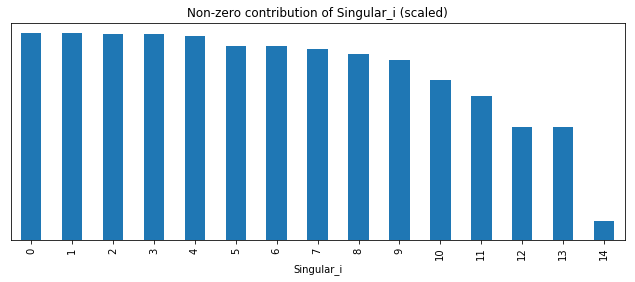

In [148]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

ssa.view_s_contributions(adjust_scale=True)

In [165]:
slow_rho_idx = np.argmax(np.abs(ssa.U.sum(0))/(np.abs(ssa.U).sum(0)))
fast_rho_idx = np.delete(range(K),slow_rho_idx)
slow_rho_idx

0

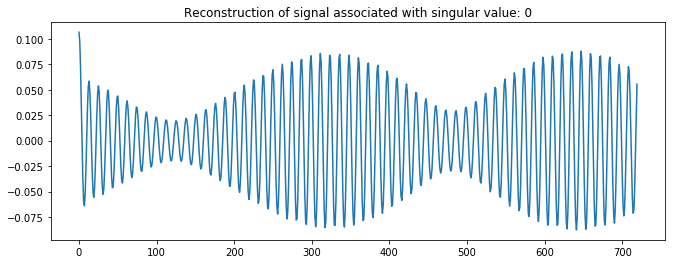

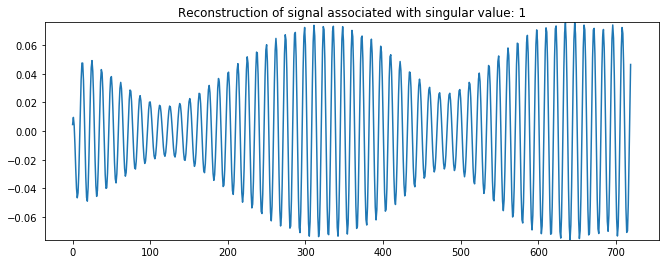

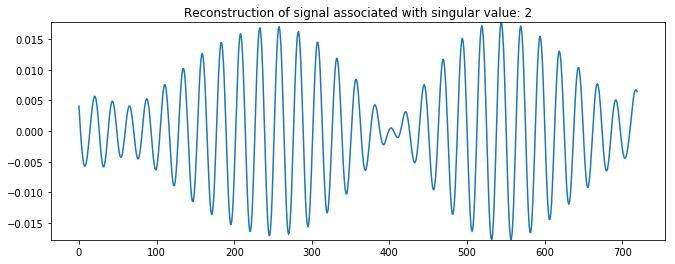

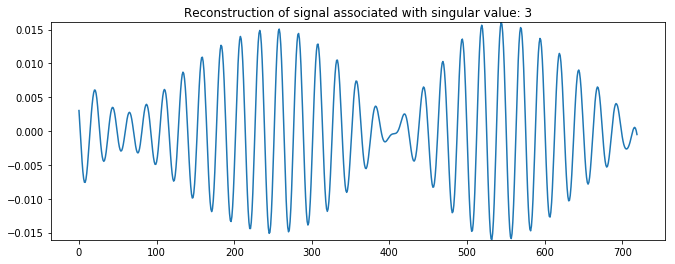

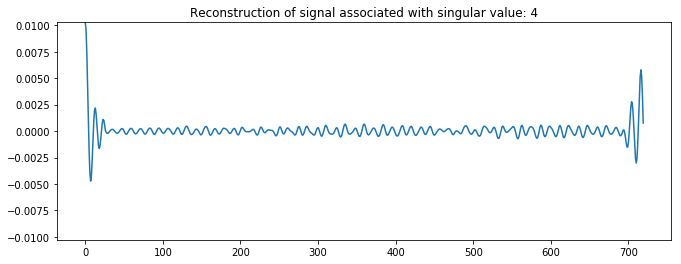

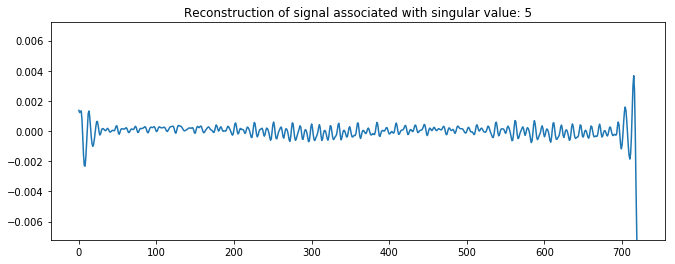

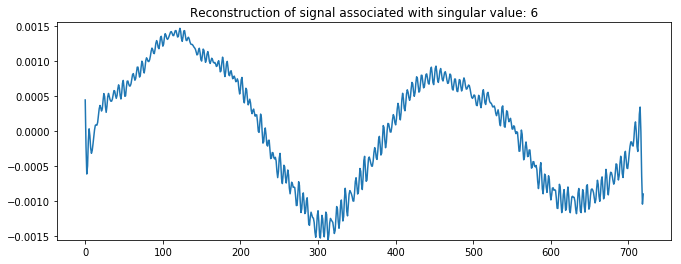

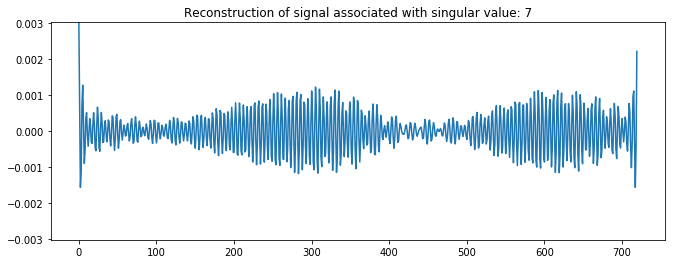

In [169]:
for i in range(8):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

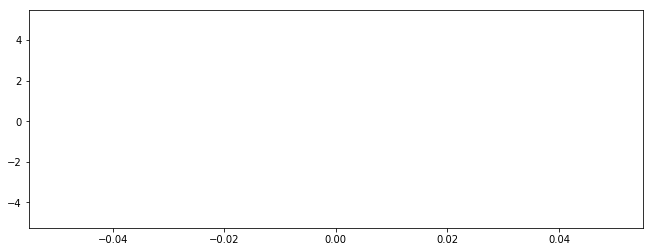

In [186]:
plt.plot(ssa.S[0,:])

In [173]:
w = np.fft.fft(ssa.S[6])
np.abs(w)

array([[ 9.64272026, 12.74841221, 62.90343168, 13.239132  ,  5.50549175,
         3.41692985,  2.50251224,  2.0160435 ,  1.71263166,  1.51745101,
         1.38914737,  1.30497941,  1.25397013,  1.22973901,  1.22973901,
         1.25397013,  1.30497941,  1.38914737,  1.51745101,  1.71263166,
         2.0160435 ,  2.50251224,  3.41692985,  5.50549175, 13.239132  ,
        62.90343168, 12.74841221]])

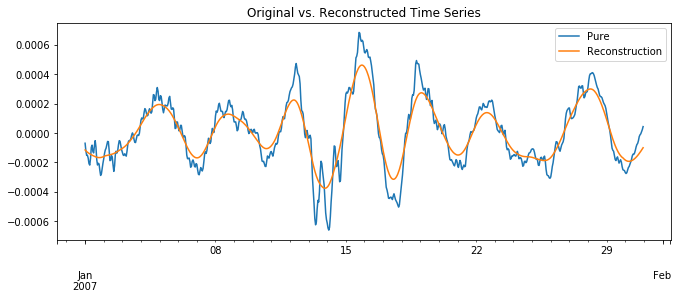

In [166]:
streams = [i for i in [0]]
reconstructed = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams], 
                                          names=streams, return_df=True, plot=False)
ts_copy2 = ssa.ts.copy()
ts_copy2['Reconstruction'] = reconstructed.Reconstruction.values
ts_copy2['Pure'] = demeaned
ts_copy2.plot(y=['Pure','Reconstruction'],title='Original vs. Reconstructed Time Series')

In [16]:
def ssa_window(K):
    ssa.embed(embedding_dimension=K)
    ssa.decompose()
    streams = [i for i in range(4)]
    reconstructed = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams], 
                                              names=streams, return_df=True, plot=False)
    ts_copy2 = ssa.ts.copy()
    ts_copy2['Reconstruction'] = reconstructed.Reconstruction.values
    ts_copy2['Pure'] = demeaned
    #ts_copy2.plot(y=['Pure','Reconstruction'],title='Original vs. Reconstructed Time Series')
    #print(np.sum(ts_copy2['Reconstruction']**2 - ts_copy2['Pure']**2)/ts_copy2['Reconstruction'].size)
    #plt.show()
    return np.sqrt(np.mean((ts_copy2['Reconstruction'] - ts_copy2['Pure'])**2))

rmses = []
ws = np.arange(4,50,2)
for i in log_progress(ws):
    rmses.append(ssa_window(i))

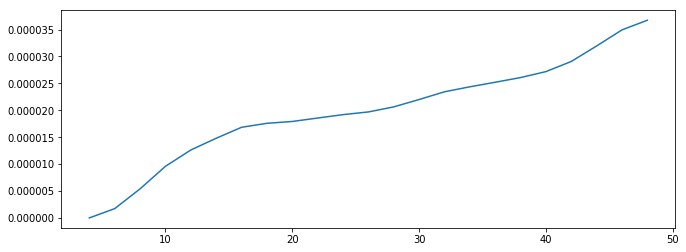

In [17]:
plt.plot(ws,rmses)

# 4. Single grid cell |u|_tide_cyclic (function)

In [5]:
file_path = os.path.join(raw_dir,'waom4_hr_nt','ocean_avg_0010.nc')
tides = xr.open_dataset(file_path,chunks={'xi_rho':75,'eta_rho':75})
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][1050:1140,95:113] = True
mask_shelf['Total Antarctica'][:,1500:] = False

grd.mask_rho[570:610,1030:1140] = False

In [6]:
def get_ssa(ts):
    demeaned = ts - ts.mean()
    ts = pd.Series(demeaned, index=pd.date_range("2007",freq='H',periods=np.size(demeaned)))
    ssa = mySSA(ts)
    ssa.embed(embedding_dimension=28)
    ssa.decompose()
    streams = [i for i in range(4)]
    return ssa.view_reconstruction(*[ssa.Xs[i] for i in streams], names=streams, return_df=True, plot=False)

# 5. map |u|_tide_cyclic (function)

In [7]:
def get_Tstar_map(Tstar,mask):
    out = np.empty_like(Tstar)
    out[:]=np.nan
    
    for j in log_progress(range(np.size(out,1)),name='eta'):
        if mask[j,:].any()==True:        
            for i in range(np.size(out,2)):           
                if (mask[j,i]==True):
                    if (np.isnan(Tstar[:,j,i]).any()==False):
                        out[:,j,i] = get_ssa(Tstar[:,j,i]).values.squeeze()
                                          
    return xr.DataArray(out,dims=('ocean_time','eta_rho','xi_rho')).where(mask)

In [8]:
sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,1100),
           'xi_u' : slice(350,649),'eta_u' : slice(700,1100),
           'xi_v' : slice(350,650),'eta_v' : slice(700,1099)}
FRIS = tides.isel(sel)
rho_sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,1100)}
FRIS_mask = ((grd.mask_rho==1) &  (grd.zice<0) &(mask_shelf['Total Antarctica']==1)).isel(rho_sel)

In [9]:
Tstar_tide = get_Tstar_map(FRIS.Tstar[:,::10,::10],FRIS_mask[::10,::10])
Tstar_tide.to_netcdf(os.path.join(int_dir,'Tstar_tide_ssa_nt.nc'))

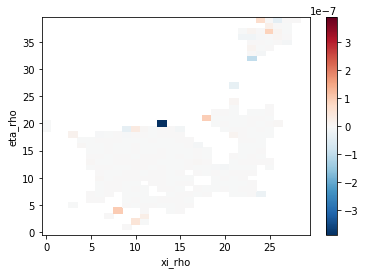

In [10]:
Tstar_tide.mean('ocean_time').plot()